## Contextual Bandits

Here is a [better rendering](https://nbviewer.org/github/facebookresearch/Pearl/blob/main/tutorials/contextual_bandits/contextual_bandits_tutorial.ipynb) of this notebook on [nbviewer](https://nbviewer.org/).

In [ ]:
%load_ext autoreload
%autoreload 2

## Installation
If you haven't installed Pearl, please make sure you install Pearl with the following cell. Otherwise, you can skip the cell below.

In [ ]:
%pip uninstall Pearl -y
%rm -rf Pearl
!git clone https://github.com/facebookresearch/Pearl.git
%cd Pearl
%pip install .
%cd ..

Cloning into 'Pearl'...
remote: Enumerating objects: 4759, done.
remote: Counting objects: 100% (972/972), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 4759 (delta 877), reused 826 (delta 811), pack-reused 3787
Receiving objects: 100% (4759/4759), 12.55 MiB | 13.86 MiB/s, done.
Resolving deltas: 100% (3207/3207), done.
/content/Pearl
Processing /content/Pearl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 22.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadat

## Import Modules

In [ ]:
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.action_representation_modules.one_hot_action_representation_module import OneHotActionTensorRepresentationModule
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import FIFOOffPolicyReplayBuffer
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.pearl_agent import PearlAgent
from pearl.utils.uci_data import download_uci_data
from pearl.utils.instantiations.environments.contextual_bandit_uci_environment import (
    SLCBEnvironment,
)
from pearl.policy_learners.exploration_modules.contextual_bandits.squarecb_exploration import SquareCBExploration
from pearl.policy_learners.exploration_modules.contextual_bandits.ucb_exploration import (
    UCBExploration,
)
from pearl.policy_learners.exploration_modules.contextual_bandits.thompson_sampling_exploration import (
    ThompsonSamplingExplorationLinear,
)
from pearl.policy_learners.contextual_bandits.neural_bandit import NeuralBandit
from pearl.policy_learners.contextual_bandits.neural_linear_bandit import (
    NeuralLinearBandit,
)
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

set_seed(0)

## Load Environment
The environment which underlies the experiments to follow is a contextual bandits environment we added to Pearl that allows to use UCI datasets (https://archive.ics.uci.edu/datasets) to built environmens to test contextual bandits algorithms.

The UCI datasets span a wide variety of prediction tasks. We use these tasks to construct a contexual bandit environment in which an agent recives an expected reward of 1 if it correctly label a data point and 0 otherwise. Pearl library currently support the following datasets: pendigits, letter, satimage, yeast. Additional ones can be readily added.

In the following experiment will test different types of contextual bandits algorithms on the pendigits UCI dataset.

In [ ]:
# Download UCI dataset if doesn't exist
uci_data_path = "./utils/instantiations/environments/uci_datasets"
if not os.path.exists(uci_data_path):
    os.makedirs(uci_data_path)
    download_uci_data(data_path=uci_data_path)

# Built CB environment using the pendigits UCI dataset
pendigits_uci_dict =  {
    "path_filename": os.path.join(uci_data_path, "pendigits/pendigits.tra"),
    "action_embeddings": "discrete",
    "delim_whitespace": False,
    "ind_to_drop": [],
    "target_column": 16,
}
env = SLCBEnvironment(**pendigits_uci_dict)

# experiment code
number_of_steps = 10000
record_period = 400

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pearl/utils/instantiations/environments/contextual_bandit_uci_environment.py:50: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, 0] = df.iloc[:, 0].cat.codes




```
# This is formatted as code
```

## Contextual Bandits learners
The following code sections show how to implement the neural versions of SquareCB, LinUCB and LinTS with the Pearl library.

## Contextual Bandits learners: SquareCB

The SquareCB algorithm requires only a regression model with which it learns the reward function. Given the reward model, SquareCB executes the following policy.
$$
\widehat{a}_*\in \arg\max_a\widehat{r}(x,a)\\
\widehat{r}_*\in \max_a\widehat{r}(x,a)\\
\text{If $a\neq \widehat{a}_*$}: \pi(a,x)= \frac{1}{A + \gamma (\widehat{r}_* - \widehat{r}(x,a))}\\
\text{If $a= \widehat{a}_*$}: \pi(a,x) = 1-\sum_{a'\neq \widehat{a}_*}\pi(a',x).
$$
This exploratiative policy, that balances exploration and exploitation in an intelligent way.

To use the SquareCB algrorithm in Pearl we set the policy learner as NeuralBandit. NeuralBandit is a base class and supports the estimation of the reward function with a neural architecture. With access to an estimated reward model, we then instantiate the exploration module with SquareCBExploration module.

To further highlight the versatility of the modular design of Pearl, we use the OneHotActionTensorRepresentationModule as the action representation module. Namley, when the action set is a finite number of elementes
$
\{1,2,.,,N\}
$
as a one-hot vector.


episode 100, step 100, agent=PearlAgent with NeuralBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: -0.15010957419872284
episode 200, step 200, agent=PearlAgent with NeuralBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: -0.08203082531690598
episode 300, step 300, agent=PearlAgent with NeuralBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: -0.03324655815958977
episode 400, step 400, agent=PearlAgent with NeuralBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 1.0116292238235474
episode 500, step 500, agent=PearlAgent with NeuralBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.8727301955223083
episode 600, step 600, agent=PearlAgent with NeuralBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 1.0681545734405518
episode 700, step 700, agent=PearlAgent with NeuralBandit, FIFOOffPolicyRepl

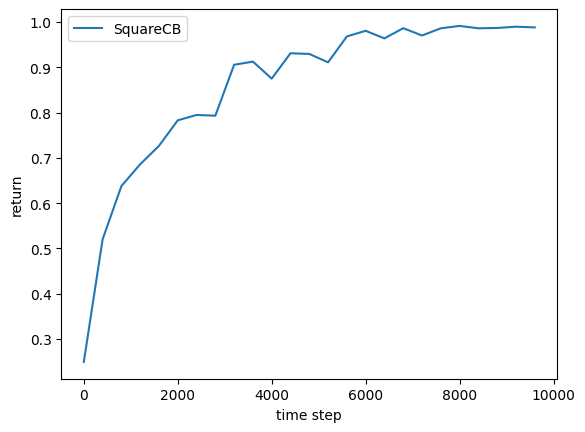

In [ ]:
# Create a Neural SquareCB pearl agent with 1-hot action representation

action_representation_module = OneHotActionTensorRepresentationModule(
    max_number_actions= env._action_space.n,
)

agent = PearlAgent(
    policy_learner=NeuralBandit(
        feature_dim = env.observation_dim + env._action_space.n,
        hidden_dims=[64, 16],
        training_rounds=50,
        action_representation_module=action_representation_module,
        exploration_module= SquareCBExploration(gamma = env.observation_dim * env._action_space.n * number_of_steps)
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(100_000),
    device_id=-1,
)


info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=record_period,
    learn_after_episode=True,
)
torch.save(info["return"], "SquareCB-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="SquareCB")
plt.xlabel("time step")
plt.ylabel("return")
plt.legend()
plt.show()

## Contextual Bandits learners: LinUCB

Next, we describe how to use the neural version of the LinUCB algorithm with the Pearl library, which uses UCB type of exploration with neural architectures. The LinUCB and its neural version, are generalizations of the seminal Upper Confidence Bound (UCB) algorithm. Both execute a policy of the following form:
$$
\pi(a,x) \in \arg\max_a \widehat{r}(x,a) + \mathrm{score}(x,a),
$$
namely, both uses a function that estimates the expected reward with an additional bonus term, that quantifies the potential of choosing an action given a certain context. A common way to estimate the score function, in the linear case, when the features are $\phi(x,a)$ is via:
$$
\mathrm{score}(x,a) = \alpha ||\phi(x,a) ||_{A^{-1}}\\
\text{where } A= \lambda I + \sum_{n\leq t} \phi(x_n,a_n)\phi^T(x_n,a_n).
$$

To implement the LinUCB algorithm in Pearl, use the NeuralLinearBandit policy learner module. This module supports (i) learning a reward model, and, (ii) calculates a score function by estimating the uncertainty using the last layer features. Further, set the exploration module to be UCBExploration and set the alpha hyper-parameters to enable the agent with the UCB-like update rule.


episode 100, step 100, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: -0.028449539095163345
episode 200, step 200, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.07872921228408813
episode 300, step 300, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.9911090135574341
episode 400, step 400, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.059778787195682526
episode 500, step 500, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: -0.036440279334783554
episode 600, step 600, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: -0.14758507907390594
episode 700, step 700, agent=PearlA

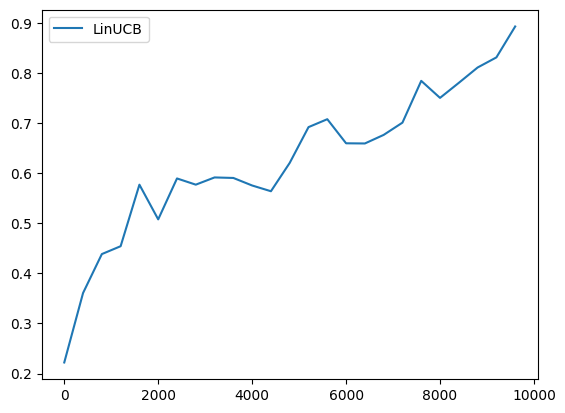

In [ ]:
# Create a Neural LinUCB pearl agent with 1-hot action representation

action_representation_module = OneHotActionTensorRepresentationModule(
    max_number_actions= env._action_space.n,
)

agent = PearlAgent(
    policy_learner=NeuralLinearBandit(
        feature_dim = env.observation_dim + env._action_space.n,
        hidden_dims=[64, 16],
        training_rounds=50,
        action_representation_module=action_representation_module,
        exploration_module= UCBExploration(alpha=1.0)
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(100_000),
    device_id=-1,
)


info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=record_period,
    learn_after_episode=True,
)
torch.save(info["return"], "LinUCB-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="LinUCB")
plt.xlabel("time step")
plt.ylabel("return")
plt.legend()
plt.show()

## Contextual Bandits learners: LinTS

Lastly, we describe how to use the neural version of the LinTS algorithm with the Pearl library, namely, the algorithm which uses Thompson sampling exploration with neural architectures. The LinTS sampling is closely related to the LinUCB algorithm, with a key modification that often improves its convergence in practice: sample the score function from a probability, instead of fixing it determinstically. Practically, this often reduces over-exploring arms, since the score may be smaller than in the LinUCB algorithm.

To implement the LinTS algorithm in Pearl, use the NeuralLinearBandit policy learner module. Further, set the exploration module to be ThompsonSamplingExplorationLinear. This enables the agent to sample the score based on its estimated uncertainty, rather to fix it as in LinUCB algorithm.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


episode 100, step 100, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: -6.782996206311509e-05
episode 200, step 200, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 1.0620898008346558
episode 300, step 300, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 1.128913164138794
episode 400, step 400, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 1.0612578392028809
episode 500, step 500, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 1.01449716091156
episode 600, step 600, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: -0.14748625457286835
episode 700, step 700, agent=PearlAgent wit

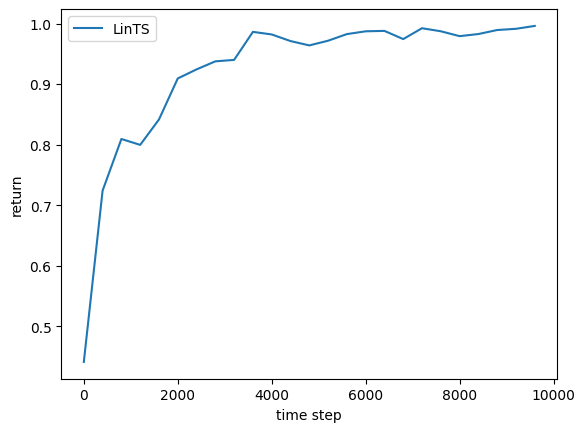

In [ ]:
# Create a Neural LinTS pearl agent with 1-hot action representation

action_representation_module = OneHotActionTensorRepresentationModule(
    max_number_actions= env._action_space.n,
)

agent = PearlAgent(
    policy_learner=NeuralLinearBandit(
        feature_dim = env.observation_dim + env._action_space.n,
        hidden_dims=[64, 16],
        training_rounds=50,
        action_representation_module=action_representation_module,
        exploration_module= ThompsonSamplingExplorationLinear()
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(100_000),
    device_id=-1,
)


info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=record_period,
    learn_after_episode=True,
)
torch.save(info["return"], "LinTS-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="LinTS")
plt.xlabel("time step")
plt.ylabel("return")
plt.legend()
plt.show()

## Summary
In this example, we showed how to use popular contextual bandits algorithms in Pearl. The figures that should be obtained upon running this code can be found in:
pearl/tutorials/cb_algorithms/cb_algorithms.png.
